<div align="right">Бронников Егор ПМ-1901</div>

<h1 align="center">Индивидуальное задание: Построение модели SARIMA</h1>

### Импорт модулей

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import boxcox

from itertools import product

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
%matplotlib inline

### Данные

In [2]:
df = pd.read_csv("data/cfe-specialty-writing-papers-mon.csv", index_col="Month", parse_dates=True)
df = df.rename(columns={"CFE specialty writing papers monthly sales": "CFE"})

In [3]:
df.head()

,CFE
Month,
1-01,1359.795
1-02,1278.564
1-03,1508.327
1-04,1419.710
1-05,1440.510


Для более точного прогноза нам следует избавиться от последних трёх записей, так как они не составляют полного периода.

In [4]:
df = df[:-3]

В связи с тем, что колонка с месяцем получилось довольной странного формата, её нужно преобразовать в удобный формат.

Допустим, что рассматриваются 2000-е.

In [5]:
def convert_date(date: str):
    year, month = map(int, date.split("-"))
    year += 2000
    return pd.to_datetime("-".join(str(elem) for elem in [year, month]))

In [6]:
df = df["CFE"]
df.index = pd.DatetimeIndex(map(convert_date , df.index), freq="MS")

In [7]:
df.head()

2001-01-01    1359.795
2001-02-01    1278.564
2001-03-01    1508.327
2001-04-01    1419.710
2001-05-01    1440.510
Freq: MS, Name: CFE, dtype: float64

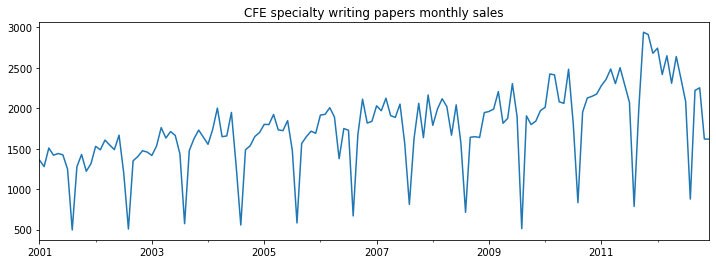

In [8]:
df.plot(figsize=(12,4))
plt.title("CFE specialty writing papers monthly sales")
plt.show()

Из прошлого индивидуального задания было известно, что в данных имеется сезонность каждые 12 месяцев.

### Автокорреляция и частичная автокорреляция

In [9]:
df_transformed, lmbda = boxcox(df)
y_transformation = pd.DataFrame(df.values, columns=["initial"])
y_transformation["transformed"] = df_transformed
y_transformation["seasonal_diff"] = y_transformation["transformed"].diff(12)
y_transformation["lag1_diff"] = y_transformation["seasonal_diff"].diff(1)

In [10]:
print("Критерий Дики-Фуллера для исходного ряда: p=%f" % adfuller(y_transformation["initial"])[1])
print("После преобразования Бокса-Кокса: p=%f" % adfuller(y_transformation["transformed"])[1])
print("После сезонного дифференцирования: p=%f" % adfuller(y_transformation["seasonal_diff"].dropna())[1])
print("После дополнительного дифференцирования: p=%f" % adfuller(y_transformation["lag1_diff"].dropna())[1])

Критерий Дики-Фуллера для исходного ряда: p=0.539894
После преобразования Бокса-Кокса: p=0.512066
После сезонного дифференцирования: p=0.007034
После дополнительного дифференцирования: p=0.617496


Рассмотрим коррелограмму исходного ряда.

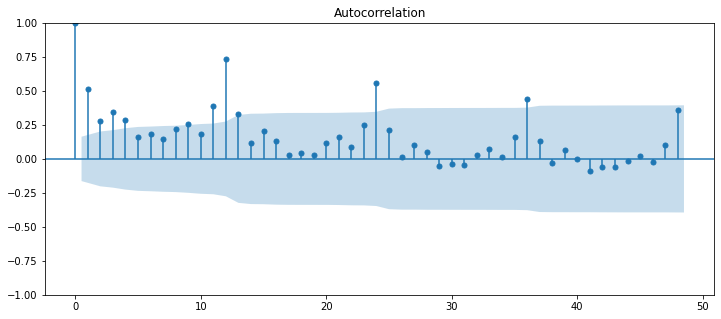

In [11]:
plt.rcParams["figure.figsize"] = (12,5)
plot_acf(y_transformation["initial"].dropna(), lags=48)
plt.show()

Рассмотрим коррелограмму полученного ряда.

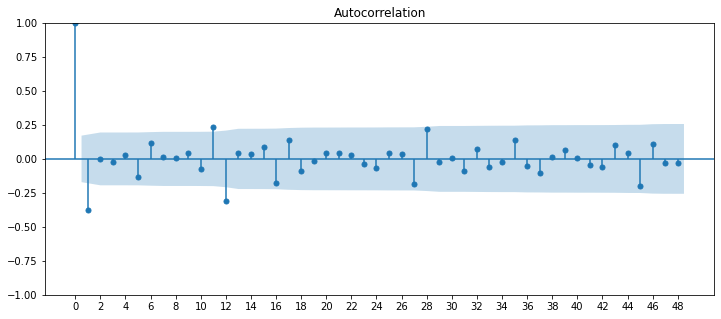

In [12]:
plt.rcParams["figure.figsize"] = (12,5)
plot_acf(y_transformation["lag1_diff"].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

По данной коррелограмме можно сделать вывод, что: $q \in [0;3)$.

Построим график частичной автокорреляции полученного ряда.

/home/levi/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


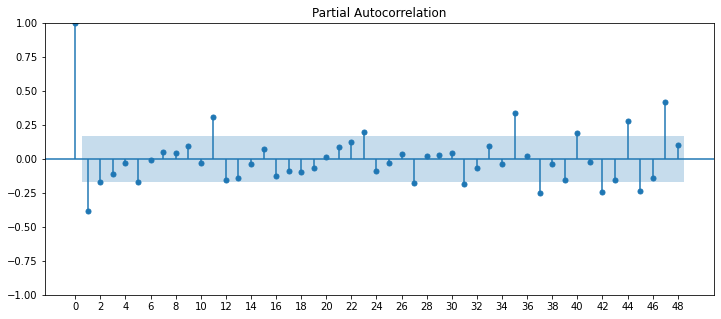

In [13]:
plt.rcParams["figure.figsize"] = (12,5)
plot_pacf(y_transformation["lag1_diff"].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

По данной коррелограмме можно сделать вывод, что: $p \in [0;4)$.

###  Построение модели SARIMA

Перебираем все параметры.

In [22]:
p = range(0, 4)
q = range(0, 3)
P = range(0, 2)
Q = range(0, 2)
d = 1

In [23]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

48

In [24]:
d = 1
D = 1

aic_dict = {}

for i in range(len(parameters_list)):
    p, q, P, Q = parameters_list[i]
    model = SARIMAX(y_transformation["initial"],
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, 12)).fit()
    aic_dict[i] = [parameters_list[i], model.aic]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.33701D+00    |proj g|=  3.69937D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      5      1     0     0   1.361D-06   6.335D+00
  F =   6.3349055815125688     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.2

 This problem is unconstrained.



At iterate    5    f=  6.24403D+00    |proj g|=  4.19645D-03

At iterate   10    f=  6.22787D+00    |proj g|=  4.43566D-02

At iterate   15    f=  6.22125D+00    |proj g|=  5.84217D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     17      1     0     0   5.842D-06   6.221D+00
  F =   6.2212548481884831     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27550D+00    |proj g|=  1.93538D-02

At iterate    5    f=  6.27515D+00    |proj g|=  7.74561D-04

At iterate   10    f=  6.27489D+00    |proj g|=  1.37708D-02

At iterate   15    f=  6.27443D+00    |proj g|=  1.00113D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     19      1     0     0   1.021D-07   6.274D+00
  F =   6.2744264690044149     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  6.23871D+00    |proj g|=  1.00411D-03

At iterate   10    f=  6.23691D+00    |proj g|=  6.42982D-03

At iterate   15    f=  6.21459D+00    |proj g|=  1.64259D-03

At iterate   20    f=  6.21453D+00    |proj g|=  1.97077D-03

At iterate   25    f=  6.21417D+00    |proj g|=  1.34855D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     50      1     0     0   6.769D-06   6.213D+00
  F =   6.2133883222605153     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.



At iterate    5    f=  6.22925D+00    |proj g|=  5.15727D-04

At iterate   10    f=  6.22913D+00    |proj g|=  7.04268D-03

At iterate   15    f=  6.22894D+00    |proj g|=  2.09521D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     17      1     0     0   2.095D-06   6.229D+00
  F =   6.2289356940635487     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13849D+00    |proj g|=  2.84744D-02

At iterate    5    f=  6.13506D+00    |proj g|=  2.38731D-03

At iterate   10    f=  6.12311D+00    |proj g|=  1.25596D-02

At iterate   15    f=  6.10727D+00    |proj g|=  2.18732D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     33      1     0     0   8.261D-07   6.107D+00
  F =   6.1071677918552627     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  6.17499D+00    |proj g|=  1.18206D-03

At iterate   10    f=  6.17346D+00    |proj g|=  2.42030D-02

At iterate   15    f=  6.16732D+00    |proj g|=  1.31930D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     19      1     0     0   5.611D-06   6.167D+00
  F =   6.1673104004149106     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14724D+00    |proj g|=  3.19304D-02

At iterate    5    f=  6.13344D+00    |proj g|=  1.20261D-03

At iterate   10    f=  6.12935D+00    |proj g|=  7.11597D-03

At iterate   15    f=  6.10544D+00    |proj g|=  2.60133D-03

At iterate   20    f=  6.10542D+00    |proj g|=  1.54374D-03

At iterate   25    f=  6.10500D+00    |proj g|=  2.33301D-02

At iterate   30    f=  6.10387D+00    |proj g|=  7.05900D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  6.22853D+00    |proj g|=  2.11529D-04

At iterate   10    f=  6.22841D+00    |proj g|=  7.43316D-03

At iterate   15    f=  6.22784D+00    |proj g|=  1.06519D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   3.636D-06   6.228D+00
  F =   6.2278346119290138     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13847D+00    |proj g|=  2.18246D-02


 This problem is unconstrained.



At iterate    5    f=  6.13521D+00    |proj g|=  1.24047D-03

At iterate   10    f=  6.12899D+00    |proj g|=  1.66680D-02

At iterate   15    f=  6.11147D+00    |proj g|=  2.55793D-03

At iterate   20    f=  6.10506D+00    |proj g|=  1.78110D-02

At iterate   25    f=  6.10363D+00    |proj g|=  7.14818D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     37      1     0     0   1.388D-06   6.104D+00
  F =   6.1036286235349664     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  6.17427D+00    |proj g|=  7.40216D-04

At iterate   10    f=  6.17330D+00    |proj g|=  1.82358D-02

At iterate   15    f=  6.16496D+00    |proj g|=  5.58882D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   1.954D-06   6.165D+00
  F =   6.1647789138930316     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14689D+00    |proj g|=  2.92304D-02


 This problem is unconstrained.



At iterate    5    f=  6.13379D+00    |proj g|=  1.81248D-03

At iterate   10    f=  6.13316D+00    |proj g|=  1.02863D-02

At iterate   15    f=  6.10763D+00    |proj g|=  5.60092D-02

At iterate   20    f=  6.10184D+00    |proj g|=  4.87933D-04

At iterate   25    f=  6.10083D+00    |proj g|=  4.86962D-03

At iterate   30    f=  6.10066D+00    |proj g|=  3.43430D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     40      1     0     0   8.164D-06   6.101D+00
  F =   6.1006595931449725     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.25205D+00    |proj g|=  2.15212D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   2.866D-05   6.252D+00
  F =   6.2520502062625631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.1

 This problem is unconstrained.



At iterate    5    f=  6.16044D+00    |proj g|=  2.72102D-03

At iterate   10    f=  6.15756D+00    |proj g|=  5.16492D-02

At iterate   15    f=  6.14092D+00    |proj g|=  1.34975D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     20      1     0     0   4.035D-07   6.141D+00
  F =   6.1409126386775341     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.19879D+00    |proj g|=  1.03695D-02

At iterate    5    f=  6.19861D+00    |proj g|=  2.62086D-03

At iterate   10    f=  6.19644D+00    |proj g|=  3.05971D-02

At iterate   15    f=  6.19376D+00    |proj g|=  6.78393D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     19      1     0     0   3.926D-07   6.194D+00
  F =   6.1937629798292022     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.17040D+00    |proj g|=  4.64867D-02

At iterate    5    f=  6.15700D+00    |proj g|=  1.18157D-03

At iterate   10    f=  6.15675D+00    |proj g|=  3.64732D-03

At iterate   15    f=  6.14339D+00    |proj g|=  5.57945D-02

At iterate   20    f=  6.13722D+00    |proj g|=  2.49997D-04

At iterate   25    f=  6.13525D+00    |proj g|=  9.32523D-03

At iterate   30    f=  6.13500D+00    |proj g|=  2.70341D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  6.22794D+00    |proj g|=  1.57850D-04

At iterate   10    f=  6.22793D+00    |proj g|=  1.45011D-03

At iterate   15    f=  6.22767D+00    |proj g|=  5.35790D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     23      1     0     0   5.699D-07   6.228D+00
  F =   6.2275638768127060     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13830D+00    |proj g|=  2.81941D-02


 This problem is unconstrained.



At iterate    5    f=  6.13263D+00    |proj g|=  2.72855D-03

At iterate   10    f=  6.13212D+00    |proj g|=  1.01823D-02

At iterate   15    f=  6.11138D+00    |proj g|=  1.66729D-02

At iterate   20    f=  6.11035D+00    |proj g|=  4.12136D-04

At iterate   25    f=  6.10992D+00    |proj g|=  7.37611D-03

At iterate   30    f=  6.10969D+00    |proj g|=  1.53970D-03

At iterate   35    f=  6.10967D+00    |proj g|=  2.22172D-05

At iterate   40    f=  6.10967D+00    |proj g|=  2.40494D-05

At iterate   45    f=  6.10967D+00    |proj g|=  1.64264D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45     51   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.17606D+00    |proj g|=  2.53628D-02

At iterate    5    f=  6.17249D+00    |proj g|=  7.00520D-04

At iterate   10    f=  6.17223D+00    |proj g|=  6.81645D-03

At iterate   15    f=  6.16547D+00    |proj g|=  1.61252D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   5.632D-06   6.164D+00
  F =   6.1641838236299300     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14703D+00    |proj g|=  3.17304D-02

At iterate    5    f=  6.13121D+00    |proj g|=  1.22723D-03

At iterate   10    f=  6.13066D+00    |proj g|=  4.02089D-03

At iterate   15    f=  6.11364D+00    |proj g|=  5.62543D-02

At iterate   20    f=  6.10758D+00    |proj g|=  5.13831D-04

At iterate   25    f=  6.10720D+00    |proj g|=  8.58762D-04

At iterate   30    f=  6.10663D+00    |proj g|=  1.49778D-03

At iterate   35    f=  6.10655D+00    |proj g|=  1.01477D-04

At iterate   40    f=  6.10654D+00    |proj g|=  5.46794D-04

At iterate   45    f=  6.10654D+00    |proj g|=  6.07579D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.34455D+00    |proj g|=  4.53077D-01

At iterate    5    f=  6.22882D+00    |proj g|=  1.03918D-03

At iterate   10    f=  6.22774D+00    |proj g|=  5.73274D-03

At iterate   15    f=  6.22764D+00    |proj g|=  1.51656D-04

At iterate   20    f=  6.22763D+00    |proj g|=  1.96117D-03

At iterate   25    f=  6.22746D+00    |proj g|=  1.09538D-02

At iterate   30    f=  6.22729D+00    |proj g|=  1.59611D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22603D+00    |proj g|=  3.36267D-01

At iterate    5    f=  6.13391D+00    |proj g|=  4.84958D-03

At iterate   10    f=  6.13336D+00    |proj g|=  8.66307D-03

At iterate   15    f=  6.13109D+00    |proj g|=  5.37740D-03

At iterate   20    f=  6.12601D+00    |proj g|=  3.75416D-02

At iterate   25    f=  6.10686D+00    |proj g|=  3.73582D-03

At iterate   30    f=  6.10673D+00    |proj g|=  9.72985D-04

At iterate   35    f=  6.10006D+00    |proj g|=  1.34504D-02

At iterate   40    f=  6.09825D+00    |proj g|=  5.41336D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27533D+00    |proj g|=  3.86881D-01

At iterate    5    f=  6.17374D+00    |proj g|=  1.50886D-03

At iterate   10    f=  6.17301D+00    |proj g|=  1.54523D-02

At iterate   15    f=  6.17175D+00    |proj g|=  2.38807D-03

At iterate   20    f=  6.17159D+00    |proj g|=  1.62500D-03

At iterate   25    f=  6.16794D+00    |proj g|=  3.42347D-02

At iterate   30    f=  6.16321D+00    |proj g|=  3.22969D-03

At iterate   35    f=  6.16116D+00    |proj g|=  1.15625D-02

At iterate   40    f=  6.15913D+00    |proj g|=  3.21326D-03

At iterate   45    f=  6.15893D+00    |proj g|=  9.33324D-04

At iterate   50    f=  6.15892D+00    |proj g|=  8.49238D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/levi/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.23933D+00    |proj g|=  3.51861D-01

At iterate    5    f=  6.13342D+00    |proj g|=  1.38809D-02

At iterate   10    f=  6.13205D+00    |proj g|=  1.77931D-03

At iterate   15    f=  6.13016D+00    |proj g|=  4.91338D-03

At iterate   20    f=  6.12968D+00    |proj g|=  3.40606D-03

At iterate   25    f=  6.12397D+00    |proj g|=  3.53178D-02

At iterate   30    f=  6.10273D+00    |proj g|=  3.44920D-03

At iterate   35    f=  6.09638D+00    |proj g|=  1.47371D-03

At iterate   40    f=  6.09574D+00    |proj g|=  1.11389D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  6.23911D+00    |proj g|=  9.84792D-04

At iterate   10    f=  6.23907D+00    |proj g|=  2.01203D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   3.946D-06   6.239D+00
  F =   6.2390723667596539     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14762D+00    |proj g|=  1.42965D-02

At iterate    5    f=  6.14672D+00    |proj g|=  1.24148D-03

At iterate   10    f=  6.14148D+00    |proj g|=  1.71735D-02

At iterate   15    f=  6.13341D+00    |proj g|=  2.92580D-02

At iterate   20    f=  6.12521D+00    |proj g|=  3.03040D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     29      1     0     0   8.706D-06   6.125D+00
  F =   6.1252005893458721     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  6.18445D+00    |proj g|=  1.79866D-03

At iterate   10    f=  6.18338D+00    |proj g|=  2.87665D-02

At iterate   15    f=  6.17882D+00    |proj g|=  7.64520D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     20      1     0     0   8.871D-07   6.179D+00
  F =   6.1788208879611561     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15632D+00    |proj g|=  3.64700D-02

At iterate    5    f=  6.14403D+00    |proj g|=  1.09548D-03

At iterate   10    f=  6.14363D+00    |proj g|=  4.87150D-03

At iterate   15    f=  6.12768D+00    |proj g|=  9.32396D-02

At iterate   20    f=  6.12165D+00    |proj g|=  2.67603D-04

At iterate   25    f=  6.12064D+00    |proj g|=  5.62555D-03

At iterate   30    f=  6.12018D+00    |proj g|=  6.23742D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  6.22884D+00    |proj g|=  1.25370D-02

At iterate   10    f=  6.22743D+00    |proj g|=  1.11566D-02

At iterate   15    f=  6.22723D+00    |proj g|=  1.48684D-04

At iterate   20    f=  6.22718D+00    |proj g|=  3.30558D-03

At iterate   25    f=  6.22690D+00    |proj g|=  2.01946D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     34      1     0     0   1.072D-07   6.227D+00
  F =   6.2268916606039033     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  6.13304D+00    |proj g|=  1.94407D-03

At iterate   10    f=  6.13146D+00    |proj g|=  3.08764D-03

At iterate   15    f=  6.13118D+00    |proj g|=  4.79356D-03

At iterate   20    f=  6.11451D+00    |proj g|=  9.48834D-02

At iterate   25    f=  6.10274D+00    |proj g|=  8.59708D-04

At iterate   30    f=  6.10273D+00    |proj g|=  8.01270D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     33      1     0     0   8.013D-06   6.103D+00
  F =   6.1027304487295781     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.17378D+00    |proj g|=  1.53399D-02

At iterate    5    f=  6.17291D+00    |proj g|=  4.93559D-03

At iterate   10    f=  6.17145D+00    |proj g|=  6.92271D-04

At iterate   15    f=  6.17127D+00    |proj g|=  7.94585D-03

At iterate   20    f=  6.16641D+00    |proj g|=  3.03561D-02

At iterate   25    f=  6.16340D+00    |proj g|=  1.07986D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     34      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.13163D+00    |proj g|=  1.99484D-03

At iterate   10    f=  6.13002D+00    |proj g|=  7.64217D-03

At iterate   15    f=  6.12969D+00    |proj g|=  2.28306D-03

At iterate   20    f=  6.11629D+00    |proj g|=  5.71342D-02

At iterate   25    f=  6.10125D+00    |proj g|=  3.74640D-03

At iterate   30    f=  6.10059D+00    |proj g|=  2.04113D-02

At iterate   35    f=  6.09987D+00    |proj g|=  1.12743D-03

At iterate   40    f=  6.09985D+00    |proj g|=  1.10257D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     56      1     0     0   9.998D-06   6.100D+00
  F =   6.09984327809

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.34559D+00    |proj g|=  4.57660D-01

At iterate    5    f=  6.22713D+00    |proj g|=  3.05993D-02

At iterate   10    f=  6.22608D+00    |proj g|=  2.36398D-03

At iterate   15    f=  6.22552D+00    |proj g|=  7.87243D-03

At iterate   20    f=  6.22544D+00    |proj g|=  1.34553D-04

At iterate   25    f=  6.22543D+00    |proj g|=  1.32313D-03

At iterate   30    f=  6.22525D+00    |proj g|=  4.32920D-03

At iterate   35    f=  6.22517D+00    |proj g|=  1.91783D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22567D+00    |proj g|=  3.39662D-01

At iterate    5    f=  6.13124D+00    |proj g|=  2.38299D-02

At iterate   10    f=  6.13013D+00    |proj g|=  2.56609D-03

At iterate   15    f=  6.12876D+00    |proj g|=  1.03279D-02

At iterate   20    f=  6.12549D+00    |proj g|=  5.68766D-03

At iterate   25    f=  6.10318D+00    |proj g|=  3.05380D-03

At iterate   30    f=  6.10310D+00    |proj g|=  1.04355D-04

At iterate   35    f=  6.10309D+00    |proj g|=  5.94119D-04

At iterate   40    f=  6.10308D+00    |proj g|=  1.09457D-04

At iterate   45    f=  6.10308D+00    |proj g|=  1.53899D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27560D+00    |proj g|=  3.90791D-01

At iterate    5    f=  6.17167D+00    |proj g|=  2.60944D-02

At iterate   10    f=  6.17081D+00    |proj g|=  7.14328D-04

At iterate   15    f=  6.17015D+00    |proj g|=  1.31588D-02

At iterate   20    f=  6.16929D+00    |proj g|=  4.45676D-03

At iterate   25    f=  6.16763D+00    |proj g|=  2.92033D-02

At iterate   30    f=  6.16449D+00    |proj g|=  4.49395D-03

At iterate   35    f=  6.16409D+00    |proj g|=  6.29973D-03

At iterate   40    f=  6.16377D+00    |proj g|=  1.36695D-03

At iterate   45    f=  6.16373D+00    |proj g|=  1.97950D-04

At iterate   50    f=  6.16373D+00    |proj g|=  5.04096D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/levi/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.23913D+00    |proj g|=  3.55414D-01


 This problem is unconstrained.



At iterate    5    f=  6.13126D+00    |proj g|=  3.54027D-02

At iterate   10    f=  6.12857D+00    |proj g|=  2.33263D-03

At iterate   15    f=  6.12633D+00    |proj g|=  6.83548D-03

At iterate   20    f=  6.12557D+00    |proj g|=  4.67084D-03

At iterate   25    f=  6.12113D+00    |proj g|=  8.84387D-03

At iterate   30    f=  6.10247D+00    |proj g|=  1.63075D-02

At iterate   35    f=  6.10015D+00    |proj g|=  9.75023D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     48      1     0     0   2.870D-06   6.100D+00
  F =   6.1001526408607702     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  6.23158D+00    |proj g|=  8.41597D-05

At iterate   10    f=  6.23158D+00    |proj g|=  1.92338D-03

At iterate   15    f=  6.23149D+00    |proj g|=  2.53468D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   1.169D-07   6.231D+00
  F =   6.2314775808651541     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14080D+00    |proj g|=  1.95025D-02


 This problem is unconstrained.



At iterate    5    f=  6.13919D+00    |proj g|=  1.11705D-03

At iterate   10    f=  6.13790D+00    |proj g|=  1.97041D-02

At iterate   15    f=  6.12209D+00    |proj g|=  9.94989D-03

At iterate   20    f=  6.11657D+00    |proj g|=  1.53483D-02

At iterate   25    f=  6.11504D+00    |proj g|=  3.98264D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     32      1     0     0   1.213D-05   6.115D+00
  F =   6.1150394142092459     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.18169D+00    |proj g|=  3.35414D-02

At iterate    5    f=  6.18068D+00    |proj g|=  8.79416D-04

At iterate   10    f=  6.18009D+00    |proj g|=  1.56424D-02

At iterate   15    f=  6.17523D+00    |proj g|=  5.69365D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   1.922D-06   6.175D+00
  F =   6.1751627078408839     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  6.13597D+00    |proj g|=  2.01176D-03

At iterate   10    f=  6.13581D+00    |proj g|=  2.81459D-03

At iterate   15    f=  6.12004D+00    |proj g|=  6.74921D-02

At iterate   20    f=  6.10968D+00    |proj g|=  5.26513D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     28      1     0     0   6.916D-05   6.110D+00
  F =   6.1096760354345747     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22963D+00    |proj g|=  1.46405D-02

At iterate    5    f=  6.22776D+00    |proj g|=  3.08384D-02

At iterate   10    f=  6.22614D+00    |proj g|=  2.54851D-04

At iterate   15    f=  6.22613D+00    |proj g|=  1.82393D-03

At iterate   20    f=  6.22589D+00    |proj g|=  7.57020D-03

At iterate   25    f=  6.22575D+00    |proj g|=  3.74838D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     29      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13843D+00    |proj g|=  2.28591D-02

At iterate    5    f=  6.13253D+00    |proj g|=  1.44225D-02

At iterate   10    f=  6.13108D+00    |proj g|=  2.04237D-03

At iterate   15    f=  6.12053D+00    |proj g|=  3.44873D-02

At iterate   20    f=  6.10074D+00    |proj g|=  9.76761D-03

At iterate   25    f=  6.10033D+00    |proj g|=  1.63716D-03

At iterate   30    f=  6.09948D+00    |proj g|=  6.74330D-04

At iterate   35    f=  6.09939D+00    |proj g|=  1.37070D-03

At iterate   40    f=  6.09936D+00    |proj g|=  7.00139D-05

At iterate   45    f=  6.09935D+00    |proj g|=  2.00458D-04


/home/levi/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.09935D+00    |proj g|=  1.39138D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   1.391D-05   6.099D+00
  F =   6.0993524337146532     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.17817D+00    |proj g|=  1.92761D-02


 This problem is unconstrained.



At iterate    5    f=  6.17492D+00    |proj g|=  4.50245D-02

At iterate   10    f=  6.17126D+00    |proj g|=  6.98107D-04

At iterate   15    f=  6.17091D+00    |proj g|=  7.94721D-03

At iterate   20    f=  6.16525D+00    |proj g|=  1.40973D-02

At iterate   25    f=  6.16483D+00    |proj g|=  5.18906D-03

At iterate   30    f=  6.15965D+00    |proj g|=  1.00030D-02

At iterate   35    f=  6.15920D+00    |proj g|=  5.55986D-03

At iterate   40    f=  6.15910D+00    |proj g|=  6.26147D-04

At iterate   45    f=  6.15909D+00    |proj g|=  1.48262D-04

At iterate   50    f=  6.15908D+00    |proj g|=  2.63687D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/levi/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14799D+00    |proj g|=  3.46387D-02

At iterate    5    f=  6.13095D+00    |proj g|=  6.73702D-03

At iterate   10    f=  6.12954D+00    |proj g|=  3.13091D-03

At iterate   15    f=  6.12933D+00    |proj g|=  5.65384D-03

At iterate   20    f=  6.12354D+00    |proj g|=  3.40671D-02

At iterate   25    f=  6.10156D+00    |proj g|=  3.57444D-02

At iterate   30    f=  6.09749D+00    |proj g|=  1.10546D-03

At iterate   35    f=  6.09738D+00    |proj g|=  4.31731D-03

At iterate   40    f=  6.09683D+00    |proj g|=  6.04019D-04

At iterate   45    f=  6.09674D+00    |proj g|=  6.59206D-04


/home/levi/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.09673D+00    |proj g|=  1.52976D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   1.530D-04   6.097D+00
  F =   6.0967267278735706     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.34701D+00    |proj g|=  4.63657D-01

At iterate    5    f=  6.22654D+00    |proj g|=  1.07783D-02

At iterate   10    f=  6.22538D+00    |proj g|=  1.82443D-03

At iterate   15    f=  6.22489D+00    |proj g|=  1.98835D-03

At iterate   20    f=  6.22488D+00    |proj g|=  8.94440D-05

At iterate   25    f=  6.22487D+00    |proj g|=  4.72281D-04

At iterate   30    f=  6.22477D+00    |proj g|=  1.23487D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22526D+00    |proj g|=  3.44105D-01

At iterate    5    f=  6.12962D+00    |proj g|=  1.34557D-02

At iterate   10    f=  6.12819D+00    |proj g|=  2.77522D-03

At iterate   15    f=  6.12777D+00    |proj g|=  8.56805D-03

At iterate   20    f=  6.12541D+00    |proj g|=  3.77842D-03

At iterate   25    f=  6.12312D+00    |proj g|=  7.79528D-03

At iterate   30    f=  6.11240D+00    |proj g|=  5.71734D-02

At iterate   35    f=  6.10277D+00    |proj g|=  8.23219D-04

At iterate   40    f=  6.10276D+00    |proj g|=  6.03413D-04

At iterate   45    f=  6.10273D+00    |proj g|=  3.35757D-04

At iterate   50    f=  6.10273D+00    |proj g|=  7.75926D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/levi/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27601D+00    |proj g|=  3.95906D-01


 This problem is unconstrained.



At iterate    5    f=  6.17160D+00    |proj g|=  1.81076D-02

At iterate   10    f=  6.16983D+00    |proj g|=  6.36304D-04

At iterate   15    f=  6.16933D+00    |proj g|=  1.68677D-02

At iterate   20    f=  6.16861D+00    |proj g|=  3.42494D-03

At iterate   25    f=  6.16725D+00    |proj g|=  1.98396D-02

At iterate   30    f=  6.16529D+00    |proj g|=  1.60761D-03

At iterate   35    f=  6.16457D+00    |proj g|=  2.99211D-02

At iterate   40    f=  6.16318D+00    |proj g|=  2.60725D-03

At iterate   45    f=  6.16293D+00    |proj g|=  3.22875D-03

At iterate   50    f=  6.16257D+00    |proj g|=  1.82537D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/levi/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.23895D+00    |proj g|=  3.60062D-01

At iterate    5    f=  6.12976D+00    |proj g|=  2.49316D-02

At iterate   10    f=  6.12645D+00    |proj g|=  3.07177D-03

At iterate   15    f=  6.12593D+00    |proj g|=  3.22877D-03

At iterate   20    f=  6.12424D+00    |proj g|=  6.58009D-03

At iterate   25    f=  6.12288D+00    |proj g|=  1.00038D-02

At iterate   30    f=  6.11487D+00    |proj g|=  6.75760D-02

At iterate   35    f=  6.10218D+00    |proj g|=  1.43134D-03

At iterate   40    f=  6.10023D+00    |proj g|=  8.48060D-03

At iterate   45    f=  6.09999D+00    |proj g|=  6.06681D-03

At iterate   50    f=  6.09987D+00    |proj g|=  2.77638D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/levi/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Прогноз

Построим прогноз на 3 года вперёд.

In [25]:
start = y_transformation["initial"].index[-1]
end = start + 36

In [26]:
val = min(aic_dict.items(), key=lambda x: x[1][-1])
val

(5, [(0, 1, 0, 1), 1764.8643240543156])

In [27]:
d = 1
D = 1
p, q, P, Q = aic_dict[val[0]][0]

In [28]:
model = SARIMAX(y_transformation["initial"],
                order=(p, d, q),
                seasonal_order=(P, D, Q, 12)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13849D+00    |proj g|=  2.84744D-02


 This problem is unconstrained.



At iterate    5    f=  6.13506D+00    |proj g|=  2.38731D-03

At iterate   10    f=  6.12311D+00    |proj g|=  1.25596D-02

At iterate   15    f=  6.10727D+00    |proj g|=  2.18732D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     33      1     0     0   8.261D-07   6.107D+00
  F =   6.1071677918552627     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


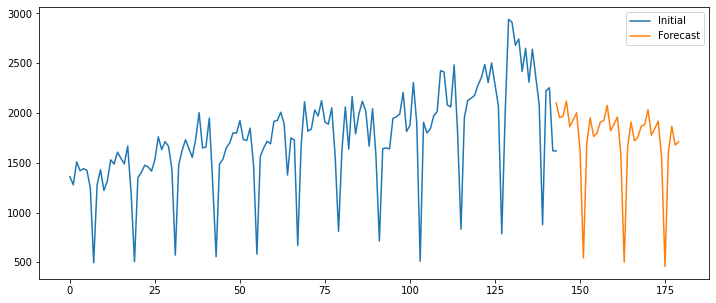

In [29]:
y_transformation["initial"].plot(figsize=(12,5))
model.predict(start=start,end=end).plot()
plt.legend(["Initial", "Forecast"])
plt.show()

По графику видно, что прогноз получился довольно спорным как и в случае первого индивидуального домашнего задания.